In [1]:
#作者：ZY，意见或讨论请联系986561785@qq.com

#导入相关函数库
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
#定义符号函数
def sign(x):
    x[x>=0] = 1
    x[x<0] =-1
    return x

In [3]:
#考虑overlap置换对称性，挑选最大的overlap组合
def overlap(ol):#ol.shape = n_h*n_h
    a = ol.shape[0]
    ol_temp = np.abs(ol)
    ol_max = np.zeros([1,a])
    for i in range(a):
        row,colunm = np.where(ol_temp == ol_temp.max())#寻找绝对值最大的ol元素行标和列标
        ol_max[0][row] = ol[row[0],colunm[0]]#将找到的最大值以行标赋值
        ol_temp[row[0],:] = 0 #取值后，同行同列置0
        ol_temp[:, colunm[0]] = 0
    return ol_max#行最大

In [4]:
def gibbs_sampling(beta,xi, alpha = 1):#xi.shape:n_v*n_h， 吉布斯抽样
    N = xi.shape[0]
    v = np.random.choice([-1,1],[1,N])
    sigma = []
    for i in range( int(alpha*N*500)+10000 ):
        
        h = sign( np.exp( beta/np.sqrt(N) * np.dot(v,xi) ) /2 /np.cosh(beta/np.sqrt(N)*np.dot(v,xi)) \
            -  np.random.uniform(0,1,[1,xi.shape[1]]))
        
        v = sign( np.exp(beta/np.sqrt(N) * (h.dot(xi.T))) /np.cosh(beta/np.sqrt(N)*(h.dot(xi.T)) )/2 \
            - np.random.uniform(0,1,[1,N]) )
        
        if ((i+1)%500 == 0) & (i>10000):
            sigma.append(v)
    return np.squeeze(np.asarray(sigma))

LB：
$$
\mathrm { LB } \left( q _ { \lambda } \right) = - \mathrm { KL } \left( q _ { \lambda } ( \xi ) \| P ( \xi ) \right) + \mathbb { E } \left[ \sum _ { a , \mu } \cosh \left( \beta X _ { \mu } ^ { a } \right) - M \ln Z ( \xi ) \right]
$$    
其中KL项：
$$ 
- \operatorname { KL } \left( q _ { \lambda } ( \xi ) \| P ( \xi ) \right) = \sum _ { x = \pm 1 } \sum _ { i , \mu } \left[ \mathcal { S } \left( \frac { 1 + \lambda _ { i \mu } x } { 2 } , \frac { 1 + m _ { i \mu } x } { 2 } \right) - \mathcal { S } \left( \frac { 1 + \lambda _ { i \mu } x } { 2 } , \frac { 1 + \lambda _ { i \mu } x } { 2 } \right) \right]
$$ 
ELL项：
$$ 
\mathbb { E } \left[ \sum _ { a , \mu } \cosh \left( \beta X _ { \mu } ^ { a } \right) - M \ln Z ( \xi ) \right] = \frac { 1 } { B _ { 1 } } \sum _ { a , \mu , s } \ln \cosh \left( \beta G _ { \mu } ^ { a } + \beta \Xi _ { \mu } z _ { \mu } ^ { s } \right) - \frac { M } { B _ { 2 } } \sum _ { s } \ln \sum _ { s } \prod _ { \mu } \cosh \left( \beta G _ { \mu } + \beta \bar { \varepsilon } _ { \mu } z _ { i } ^ { * } \right)
$$ 

权重更新：

KL项导数：
$$ 
- \frac { \partial } { \partial \lambda _ { i \mu } } \mathrm { KL } \left( q _ { \lambda } ( \xi ) \| P ( \xi ) \right) = \sum _ { x = \pm 1 } \frac { x } { 2 } \left( \ln \frac { 1 + x m _ { i \mu } } { 1 + x \lambda _ { i \mu } } - 1 \right)
$$ 

ELL第一项导数：
$$ 
\begin{aligned} \frac { \partial } { \partial \lambda _ { i \mu } } \mathbb { E } \left[ \sum _ { a , \mu } \cosh \left( \beta X _ { \mu } ^ { a } \right) \right] & \simeq \frac { \beta } { B _ { 1 } \sqrt { N } } \sum _ { a , s } \sigma _ { i } ^ { a } \tanh \left( \beta G _ { \mu } ^ { a } + \beta \Xi _ { \mu } z _ { \mu } ^ { s } \right) \\ & - \frac { \beta ^ { 2 } \lambda _ { i \mu } } { N B _ { 1 } } \sum _ { a , s } \left[ 1 - \tanh ^ { 2 } \left( \beta G _ { \mu } ^ { a } + \beta \Xi _ { \mu } z _ { \mu } ^ { s } \right) \right] \end{aligned}
$$ 
其中：
$$
\begin{array} { l } { G _ { \mu } ^ { a } = \frac { 1 } { \sqrt { N } } \sum _ { i \in \partial \mu } \lambda _ { i \mu } \sigma _ { i } ^ { a } } \\ { \Xi _ { \mu } ^ { 2 } = \frac { 1 } { N } \sum _ { i \in \partial \mu } \left( 1 - \lambda _ { i \mu } ^ { 2 } \right) } \end{array}
$$

ELL第二项等效一个连接权重为$\lambda_{i \mu}$的连续权重RBM的自由能。可用空腔方法算，迭代方程：
$$
\begin{array} { l } { m _ { i \rightarrow \nu } = \tanh \left( \sum _ { \mu \in \partial i \backslash \nu } u _ { \mu \rightarrow i } \right) } \\ { u _ { \mu \rightarrow i } = \tanh ^ { - 1 } \left( \tanh \left( \beta \chi _ { \mu \rightarrow i } + \beta H _ { \mu } \right) \tanh \left( \beta \lambda _ { i \mu } / \sqrt { N } \right) \right) } \end{array}
$$
其中：$\chi _ { \mu \rightarrow i } \equiv \frac { 1 } { \sqrt { N } } \sum _ { j \in \partial \mu \backslash i } \lambda _ { j \mu } m _ { j \rightarrow \mu }$,    $H_{\mu} = \Xi_{\mu}z_{\mu}^{s}$
进而计算自由能：
\begin{equation}
\begin{array} { l } { F _ { i } = \sum _ { \mu \in \partial _ { i } } \left[ \beta ^ { 2 } \Lambda _ { \mu \rightarrow i } ^ { 2 } / 2 + \ln \cosh \left( \beta \chi _ { \mu \rightarrow i } + \beta H _ { \mu } + \beta \lambda _ { i \mu } / \sqrt { N } \right) \right] + \ln \left( 1 + \prod _ { \mu \in \partial i } e ^ { - 2 i t _ { \mu } } \right) } \\ { F _ { \mu } = \beta ^ { 2 } \Lambda _ { \mu } ^ { 2 } / 2 + \ln \cosh \left( \beta \chi _ { \mu } + \beta H _ { \mu } \right) } \end{array}
\end{equation}

它的导数项为：
\begin{equation}
\begin{aligned} \frac { \partial } { \partial \lambda _ { i \mu } } \mathbb { E } \ln Z ( \boldsymbol { \xi } ) & \simeq \frac { \beta } { \sqrt { N } B _ { 2 } } \sum _ { s } \left\langle \sigma _ { i } \tanh \left( \beta G _ { \mu } + \beta \Xi _ { \mu } z _ { \mu } ^ { s } \right) \right\rangle \\ & - \frac { \beta \lambda _ { i \mu } } { N B _ { 2 } } \sum _ { s } \left[ \frac { z _ { \mu } ^ { s } } { \Xi _ { \mu } } \left\langle \tanh \left( \beta G _ { \mu } + \beta \Xi _ { \mu } z _ { \mu } ^ { s } \right) \right\rangle \right] \\ & = \frac { \beta } { \sqrt { N } B _ { 2 } } \sum _ { s } \left[ C _ { i \mu } - \frac { \lambda _ { i \mu } z _ { \mu } ^ { s } } { \sqrt { N } \Xi _ { \mu } } \hat { m } _ { \mu } \right] \end{aligned}
\end{equation}

其中：
\begin{equation}
\begin{array} { l } { m _ { i } = \tanh \left( \sum _ { \mu \in \partial i } u _ { \mu \rightarrow i } \right) } \\ { \hat { m } _ { \mu } = \int D z \tanh \left( \beta \tilde { \chi } _ { \mu } + \beta H _ { \mu } + \beta \tilde { \Lambda } _ { \mu } z \right) } \\ { C _ { i \mu } = \hat { m } _ { \mu } m _ { i } + \frac { \beta \lambda _ { i \mu } } { \sqrt { N } } \left( 1 - m _ { i } ^ { 2 } \right) A _ { \mu } } \\ { A _ { \mu } = 1 - \int D z \tanh ^ { 2 } \left( \beta \tilde { \chi } _ { \mu } + \beta H _ { \mu } + \beta \tilde { \Lambda } _ { \mu } z \right) } \end{array}
\end{equation}
\begin{equation}
D z \equiv e ^ { - z ^ { 2 } / 2 } / \sqrt { 2 \pi } d z , \tilde { \chi } _ { \mu } \equiv \frac { 1 } { \sqrt { N } } \sum _ { i \in \partial \mu } \lambda _ { i \mu } m _ { i } , \text { and } \tilde { \Lambda } _ { \mu } ^ { 2 } \equiv \frac { 1 } { N } \sum _ { i \in \partial \mu } \lambda _ { i \mu } ^ { 2 } \left( 1 - m _ { i } ^ { 2 } \right)
\end{equation}

In [5]:
class RBM_binary():
    
    def __init__(self,n_v,n_h,beta,lr=0.1, gamma = 0.9):
        
        self.n_v = n_v #显层神经元数量
        self.n_h = n_h #隐层神经元数量
        self.beta = beta #温度
        self.xi = np.random.choice([-1,1],[n_v,n_h]) #网络权重
        self.ld = 2*np.random.rand(n_v,n_h)-1 #lambda：网络权重的均值
        self.m = np.zeros([n_v,n_h])#先验，没有则设置为0
        self.lr = lr
        self.gamma = gamma
        self.momentum = 0
        self.KL = -1/2*( (1+self.ld)*np.log( (1+self.m)/2) + (1-self.ld)*np.log( (1-self.m)/2) \
                       - (1+self.ld)*np.log((1+self.ld)/2) - (1-self.ld)*np.log((1-self.ld)/2)).sum()
        self.LB = 0
        
    def forward(self,sigma): #隐层抽样
        return sign( np.exp( beta/np.sqrt(self.n_v) * np.dot(sigma,self.xi) ) /2 /np.cosh(beta/np.sqrt(self.n_v)*np.dot(sigma,self.xi)) \
            -  np.random.uniform(0,1,[sigma.shape[0],self.xi.shape[1]]))
    
    def backward(self,h): #显层抽样
        return sign( np.exp(beta/np.sqrt(self.n_v) * (h.dot(self.xi.T))) /np.cosh(beta/np.sqrt(self.n_v)*(h.dot(self.xi.T)) )/2 \
            - np.random.uniform(0,1,[h.shape[0],self.n_v]) )
    
        
    def train(self, sigma):#sigma.shape: [M,n_v],输入数据进行训练
        
        #KL导数项
        delta1 = 1/2*( np.log( (1+self.m)/(1+ self.ld)) - np.log((1-self.m)/(1- self.ld)) )
        
        #ELL的第一项导数值
        G = 1/np.sqrt(self.n_v)*(sigma.dot(self.ld))  #G:[M,n_h]
        Xi = np.sqrt( 1/self.n_v* (1-self.ld**2).sum(0).reshape(1,self.n_h) )  #Xi:[1,n_h]
        rn = np.random.randn(5000,1,self.n_h) #产生用于计算积分的随机数
        delta2 = self.beta/np.sqrt(self.n_v)*( (sigma.T).dot( np.tanh(self.beta*G + self.beta*Xi*rn)  ).sum(1)) /5000
        
        delta3 = -1*self.beta**2*self.ld/self.n_v * \
                 (1 - np.power( np.tanh(self.beta*G + self.beta*Xi*rn ), 2)).sum(0).sum(0).reshape(1,self.n_h) /5000
        
        #ELL的第二项导数值
        delta4 = 0
        i = 0
        F = 0
        while(i<=2000):
            rn = np.random.randn(1,self.n_h)
            b = Xi * rn
            m = np.random.rand(self.n_v,self.n_h)
            for j in range(1000): #新RBM迭代
                temp = m*1
                chi = 1/np.sqrt(self.n_v)*( (self.ld*m).sum(0) - self.ld*m).T
                u = np.arctanh( np.tanh(self.beta*chi+self.beta*b.T) *np.tanh(self.beta*self.ld.T/np.sqrt(self.n_v)))
                m = np.tanh( (u.sum(0)-u).T )
                if np.abs(m-temp).sum()<1e-6:
                    converged = True
                    break;
                if j== 999:
                    converged = False
            
            if converged:
                Lambda = np.sqrt( ((self.ld**2 * (1-m**2)).sum(0) - self.ld**2 * (1-m**2) ).T/self.n_v ).reshape(self.n_h,self.n_v)
                Fi = (self.beta**2*Lambda**2/2 + np.log(np.cosh( self.beta*chi + self.beta*b.T +self.beta*self.ld.T/np.sqrt(self.n_v)  )) ).sum()\
                    + np.log(1+np.exp(-2*u.sum(0))).sum()
                chi = 1/np.sqrt(self.n_v)*(self.ld*m).sum(0).reshape(1,self.n_h)
                Lambda = np.sqrt( (self.ld**2 * (1-m**2)).sum(0) /self.n_v ).reshape(1,self.n_h)
                Fa = (self.beta**2*Lambda**2/2 + np.log( np.cosh( self.beta*( chi + b.T ) ) )).sum()
                F += Fi - Fa*(self.n_v - 1)
                
                m = np.tanh(u.sum(0)).reshape(1,self.n_v)
                chi = 1/np.sqrt(self.n_v)*(self.ld*m.T).sum(0).reshape(1,self.n_h)
                Lambda = np.sqrt( (self.ld**2 * (1-m**2).T).sum(0) /self.n_v ).reshape(1,self.n_h)
                
                int_rn = np.random.standard_normal([2000,1,self.n_h])
                m_hat = np.tanh(self.beta * (chi + b +int_rn*Lambda)).mean(0)
                A = 1 - ( np.tanh(self.beta * (chi + b +int_rn*Lambda)) **2).mean(0)
                c = m.T.dot(m_hat) + self.beta*self.ld/np.sqrt(self.n_v) * (1-m**2).T.dot(A)
                
                delta4 += c - self.ld/np.sqrt(self.n_v)*(rn*m_hat/Xi)
                i+=1
        F = F/2000
        
        delta4 = -1*sigma.shape[0]*self.beta*delta4/2000/np.sqrt(self.n_v)
        
        #计算KL和LB
        self.KL = -1/2*( (1+self.ld)*np.log( (1+self.m)/2) + (1-self.ld)*np.log( (1-self.m)/2) \
                       - (1+self.ld)*np.log((1+self.ld)/2) - (1-self.ld)*np.log((1-self.ld)/2)).sum()
        rn = np.random.standard_normal([2000,1,self.n_h])
        ExpLL1 = np.log( np.cosh(self.beta*G + self.beta*Xi*rn) ).sum()/2000
        ExpLL2 = F
        self.LB = -1*self.KL + ExpLL1 - sigma.shape[0]*ExpLL2
        
        #动量更新
        self.momentum = self.gamma*self.momentum + self.lr*(delta1+delta2+delta3+delta4)
        self.ld += self.momentum
        
        #lambda限制，xi解码
        self.ld[self.ld>=1] = 0.999 
        self.ld[self.ld<=-1] = -0.999  
        self.xi = sign(self.ld*1)

In [6]:
n_v = 100
n_h = 3
beta = 1
xi = np.random.choice([-1,1],[n_v,n_h])#真实权重
sigma = gibbs_sampling(beta, xi, alpha = 5)#alpha，数据密度

In [7]:
rbm = RBM_binary(n_v,n_h, beta, lr = 0.4, gamma=0.9)

In [8]:
ol = []
kl = []
LB = []
for i in range(50):
    rbm.train(sigma)
    ol.append(overlap(np.abs(sign(rbm.ld*1).T.dot(xi))/100))
    kl.append(rbm.KL)
    LB.append(rbm.LB)
    if i % 20 == 0:
        rbm.lr *= 1
    print(i,overlap((sign(rbm.ld*1).T.dot(xi))/100),'KL:',rbm.KL,'  LB:',rbm.LB)

0 [[ 0.48 -0.14  0.28]] KL: 57.718411980671064   LB: 92567.69345281979
1 [[ 0.5  -0.16  0.32]] KL: 22.61544789615308   LB: 83208.32328907475
2 [[ 0.64 -0.44  0.54]] KL: 64.33251812313561   LB: 92609.9072273817
3 [[ 0.72 -0.48  0.36]] KL: 74.40758555155635   LB: 92245.21093333086
4 [[ 0.74 -0.56  0.3 ]] KL: 106.98421718455708   LB: 98473.39456805114
5 [[ 0.76 -0.66  0.24]] KL: 122.22609483578617   LB: 96566.23343743615
6 [[ 0.82 -0.78  0.1 ]] KL: 134.98593238561807   LB: 99829.2802654191
7 [[ 0.84 -0.88 -0.04]] KL: 144.33462057281093   LB: 99750.09146928744
8 [[ 0.86 -0.88 -0.08]] KL: 153.99643839210216   LB: 102329.84252387735
9 [[ 0.86 -0.92 -0.14]] KL: 159.6591484277057   LB: 103662.79357344795
10 [[ 0.86 -0.92 -0.22]] KL: 168.28718028931536   LB: 104937.02489989022
11 [[ 0.86 -0.9  -0.22]] KL: 170.82108555868604   LB: 105547.23859504871
12 [[ 0.86 -0.9  -0.18]] KL: 175.23979239761715   LB: 106062.56179153481
13 [[ 0.86 -0.9  -0.28]] KL: 178.22646173790002   LB: 106468.30770576821
14

Text(0, 0.5, 'LB')

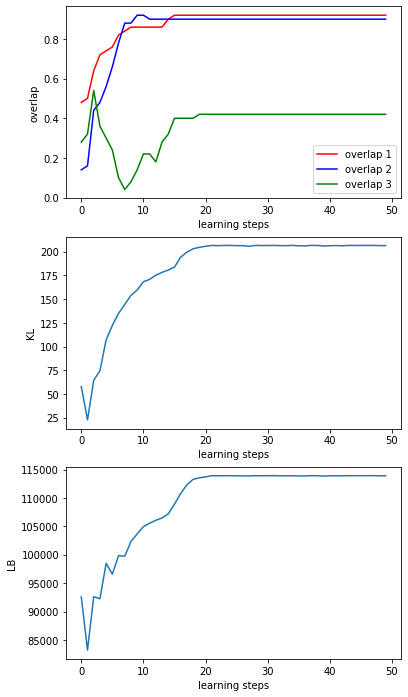

In [9]:
ol = np.asarray(ol).squeeze()
A = plt.figure(figsize=(6,12))
marks = ['r', 'b', 'g']
label = ['overlap 1','overlap 2','overlap 3']
plt.subplot(3,1,1)
for i in range(3):
    plt.plot([i for i in range(50)], ol[:,i],marks[i], label = label[i])
plt.legend()
plt.xlabel('learning steps')
plt.ylabel('overlap')
plt.subplot(3,1,2)
plt.plot([i for i in range(50)],kl)
plt.xlabel('learning steps')
plt.ylabel('KL')

plt.subplot(3,1,3)
plt.plot([i for i in range(50)], LB)
plt.xlabel('learning steps')
plt.ylabel('LB')